## Test phase consistency of tracking beam

This is a notebook showing how the new tracking beam phases were checked. This analysis is for X polarization but Y polarization yeilds similar results. Beam 10 data was used, but beam 11 is consident with these results.

In [2]:
import matplotlib.pyplot as plt
import h5py
from astropy.time import Time
import chime_frb_constants as constants
from astropy import units as apu
import glob
import numpy as np
import astropy.units as u
from baseband import vdif
from baseband_tasks.shaping import ChangeSampleShape
from baseband_tasks.fourier import fft_maker
SAMPLE_RATE = constants.FPGA_COUNTS_PER_SECOND * apu.Hz

## Load baseband data 

Reading the baseband dump from h5py because baseband-analysis is supported bt a different python I don't have in this enviroment. The baseband-analysis reader will conjugate the data if the key 'conjugate-beamform' does not exist in the data, but in this data it does exist so the result should be the same.

In [3]:
baseband_dump = h5py.File('/scratch/p/pen/atkin153/1130298123singlebeam_j20000.h5') # read bbdata

Define parameters we need from the baseband data

In [4]:
# array to hold visibilities
dump_data = baseband_dump['tiedbeam_baseband'] 
# get the index of freqs that exist in BBData (all freqs in tracking beam)
freqs = [f[0] for f in baseband_dump["index_map"]['freq']]
freq_indicies = [f[1] for f in baseband_dump["index_map"]['freq']]
# start times of bb dump for each channel
start_times = Time(list( baseband_dump['time0']["ctime"]), format = 'unix') 
# find how many frames after highest freq each freq starts
frame_add = (((start_times.unix-start_times[0].unix)/2.56e-6)).astype(int) 
# ensure we read enpugh frames so we capture the BB dump in the lowest band
frames_to_read = frame_add[-1] + dump_data.shape[-1] 
# compute phases 
bb_phase = np.angle(dump_data)

# Load tracking beam (vdif) data

This reading function is a slightly modified version of Thierry's reading function for reading CHIME vdif data. 

In [5]:
## reading function, adaprted from Thierry's code
def reshape(data_raw):
    return data_raw.reshape((-1, 128, 2))

def read_TB(files, read_time, frames):

    Nband = 8
    Nchan = 1024
    flow = 400
    fhigh = 800
    Npol = 2
    bw = int(Nchan / Nband)
    Nread =  frames
    samples_per_file = 50000
    tbin = 2.56e-6 * u.s
    N_subband = 1

    paths = files
    freqs = np.tile(np.linspace(fhigh, flow, Nchan, endpoint=False)[:,np.newaxis], (1, Npol))


    dat = [vdif.open(paths[i], 'rs', sample_rate=1/(2.56*u.us), verify=False) for i in range(8)] # open data

    for i in range(Nband): # repshape
       
        f = freqs[bw*i:bw*(i+1)]
       
        reshaped = ChangeSampleShape(dat[i], reshape)

    start_time0 = dat[0].start_time

    print(start_time0)

    #pulse_time = (pos * binning - prepulse + start_skip*samples_per_file) * tbin
    
    dstart = (dat[N_subband].start_time - start_time0).to(u.s)

    pulse_frame = int((read_time.unix - Time(start_time0, format = 'isot').unix  ) / 2.56e-6)


    
    pulse = np.zeros((Nread, 1024, 2), dtype = np.complex64)#, dtype=np.float16)
    
    for i in range(Nband):
        
        frame = dat[i]
        dstart = (frame.start_time - start_time0).to(u.s)
        print(dstart)



        frame.seek(pulse_frame)

        readpulse = frame.read(Nread).reshape(-1, bw, Npol) 
        
        pulse[:,bw*i:bw*(i+1),0] = readpulse[:,:,0]
        pulse[:,bw*i:bw*(i+1),1] = readpulse[:,:,1]

        del readpulse

    return pulse, start_time0, freqs

In [6]:
# vdif filepath 
paths =  [np.sort(glob.glob(f'/scratch/p/pen/atkin153/TRACKING_TEST/vdif_mode/*/B0329+54_20250827T130704Z_CHIME_vdif/*_0{i}.vdif')) for i in range(8)]

We read the data at the start time of the first frequency in the BBDump ( Minus 1.6ms which is the 1 vdif frame offset). Note that I modified the baseband reader to read the data as signed ints to avoid any issues, since thebbdata is read as signed ints

In [10]:
v_no_swap , start_vdif , freq_TB= read_TB(paths, start_times[0]- 1.6e-3*u.s ,frames_to_read+10) 

2025-08-27T13:12:47.094400000
0.0 s
0.0 s
0.0 s
0.0 s
0.0 s
0.0 s
0.0 s
0.0 s


In [11]:
# swap components (ideally we implement this into the reader itself eventually)
v = np.imag(v_no_swap) + 1j*(np.real(v_no_swap))

Now we want to replicate the baseband dump by reading each channel at the correct start time , using the frame differences calculated above:

In [12]:
# create new array that reads each freq at correct start
v_TB = np.zeros(shape = ( len(freq_indicies),  2,dump_data.shape[-1]), dtype = v.dtype)

for i, freq_id, frame_start in zip(np.arange(len(freq_indicies)), freq_indicies, frame_add):

    v_TB[i, 0, :] = v[frame_start: frame_start + dump_data.shape[-1], freq_id, 0]
    v_TB[i, 1, :] = v[frame_start:frame_start+ dump_data.shape[-1], freq_id, 1]


## Correlate to check small frame offset

There is an additoional 1-2 frame offset for each frequency. For each frequency, we start reading at the time of the first frequency, then calculate in frames where each channel should actually be read from ( there is a lot of converting from times <-> frames for each channel). If we calculate the actual start time for each channel , it is 1-2 frames off from where we want it to be after all those operations. So here , we correlate each frequency channel to find that small frame offset and correct. 

This is something that is important to fine-tune when a proper converter is implemented!

In [13]:
from scipy import fft

def semi_coherent_correlation(va, vb, axis=-1):
    """"
    This function is a modified version of a funciton from Tomás's baseband-tools
    """


    vaf = fft.fft(va, axis=axis)
    vbf = fft.fft(vb, axis=axis).conj()
    
    corr =  fft.ifft(vaf * vbf, axis=axis)
    corr_strength = np.abs(fft.ifftshift(corr, axes=axis))

    return corr_strength

In [15]:
# correlate
corr_1 = semi_coherent_correlation(dump_data[:, 0, :] , v_TB[:, 0,: ])


In [16]:
# get the offset by finding max correlation in each channel ( 24139 is just half the length of the array, since the fft shifts to center )
offset = np.argmax(corr_1[:, :], axis = -1)  - 24139 

In [19]:
# # plot average correlation if you  want 
# plt.plot(np.arange(-24139, 24139, 1),np.average(corr_1, axis = 0))
# plt.title('Tracking beam x bb data cross corr ')
# plt.xlabel('frame offset')
# plt.ylabel('Correlation strength (frequency averaged)')
# #plt.xlim(600, 650)

# Now correct the data for the small offset

In [20]:
# create new array that reads each freq at correct start
v_TB_o = np.zeros(shape = ( len(freq_indicies),  2,dump_data.shape[-1]), dtype = v.dtype)

for i, freq_id, frame_start in zip(np.arange(len(freq_indicies)), freq_indicies, frame_add-offset):

    v_TB_o[i, 0, :] = v[frame_start: frame_start + dump_data.shape[-1], freq_id, 0]
    v_TB_o[i, 1, :] = v[frame_start:frame_start+ dump_data.shape[-1], freq_id, 1]
TB_phase_o = np.angle(v_TB_o.conj())

## Look at the data

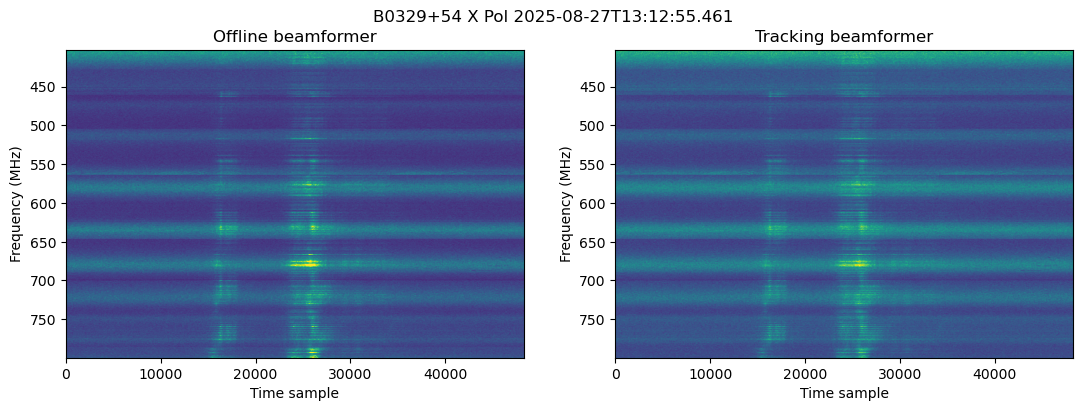

In [37]:
# plot next to eachother
fig1, ax1 = plt.subplots(1,2, figsize = (13, 4))
fig1.suptitle('B0329+54 X Pol ' + str(start_times[0].isot))
I_bb = np.abs(dump_data[:, :, :])**2
vmin, vmax=np.percentile(I_bb[:,:], [5, 95])
ax1[0].imshow(I_bb[:, 0, :], aspect = 'auto', vmin= vmin, vmax = vmax, extent = [0, len(I_bb[0, 0, :]),freqs[0], freqs[-1]])
ax1[0].set_title('Offline beamformer')
I_TB_o = np.abs(v_TB_o[:, 0, :])**2
# # look at the TB data
# I_TB = np.abs(v_TB[:, 0, :])**2 
vmin, vmax=np.percentile(I_TB_o[:,:], [5, 95])
ax1[1].imshow(I_TB_o[:, :], aspect = 'auto', vmin= vmin, vmax = vmax ,  extent = [0, len(I_bb[0, 0, :]),freqs[0], freqs[-1]])
ax1[1].set_title('Tracking beamformer')

for ax in ax1.flat:
    ax.set_xlabel('Time sample')
    ax.set_ylabel('Frequency (MHz)')
    


# Correlate again to ensure it worked

In [38]:
corr2 = semi_coherent_correlation(dump_data[:, 0, :] , v_TB_o[:, 0, :])

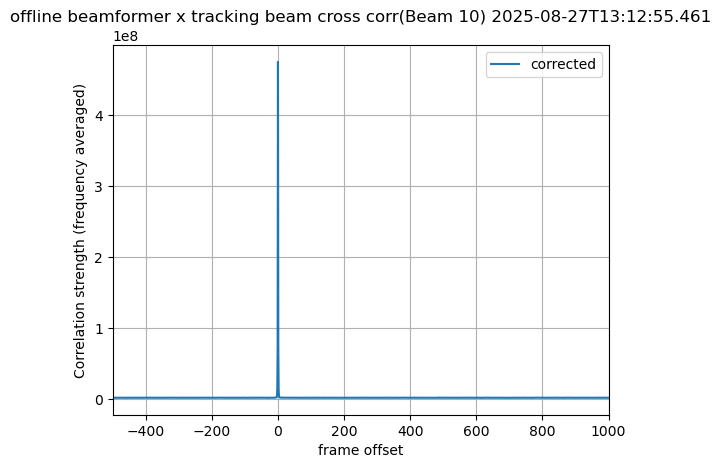

In [41]:
#plt.plot(np.arange(-24139, 24139, 1),np.average(corr_1, axis = 0), label = 'no correction')
plt.plot(np.arange(-24139, 24139, 1), np.average(corr2, axis = 0), label = 'corrected')
plt.title('offline beamformer x tracking beam cross corr(Beam 10) '+ str(start_times[0].isot))
plt.xlabel('frame offset')
plt.ylabel('Correlation strength (frequency averaged)')
plt.legend()
plt.xlim(-500, 1000)
plt.grid()

In [46]:
# check that offset is now 0 ( data is perfectly aligned in all channels)
print (np.argmax(corr2, axis = -1)- 24139)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

# Compute visibilities

In [30]:
visibilities = np.nansum(dump_data[:, 0,:]* v_TB_o[:, 0, :].conj() , axis = -1)

In [32]:
vis_phase = np.angle(visibilities)

## Look at phases

Text(0.5, 1.0, 'offline beamformer x tracking beam cross corr phases (Beam 10)  2025-08-27T13:12:55.461')

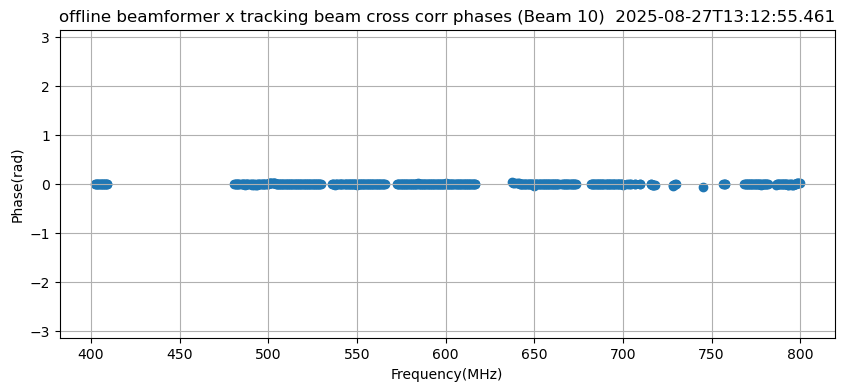

In [35]:
plt.figure(figsize = (10, 4))
plt.scatter( freqs, vis_phase)
plt.ylim(-np.pi, np.pi)
plt.ylabel('Phase(rad)')
plt.xlabel('Frequency(MHz)')
plt.grid()
plt.title(('offline beamformer x tracking beam cross corr phases (Beam 10)  '+ str(start_times[0].isot)))


# Zoom in

Text(0.5, 1.0, 'offline beamformer x tracking beam cross corr phases (Beam 10) (end of bb dump) 2025-08-27T13:12:55.461')

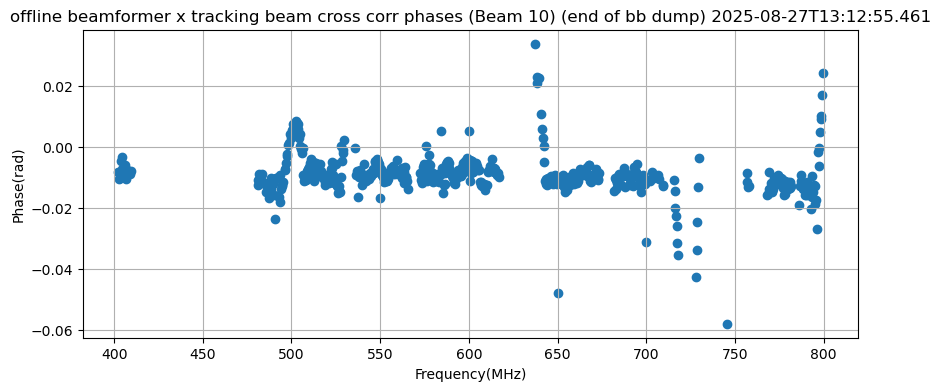

In [36]:
plt.figure(figsize = (10, 4))
plt.scatter( freqs, vis_phase)
#plt.ylim(-np.pi, np.pi)
plt.ylabel('Phase(rad)')
plt.xlabel('Frequency(MHz)')
plt.grid()
plt.title(('offline beamformer x tracking beam cross corr phases (Beam 10) (end of bb dump) '+ str(start_times[0].isot)))
